# 앙상블 학습과 랜덤 포레스트


- 투표 기반 분류기

- 배깅과 페이스팅

- 랜덤 패치와 서브 스페이스

- 랜덤 포레스트

- 부스팅

  - 에이다부스트

  - 그래이디언트 부스팅

- 스태킹


## 앙상블 학습이란


한 명의 전문가보다 다수의 노비가 더 나은 경우가 있다. 이를 대중의 지혜라고 부른다. 이 대중의 지혜를 이용하여 기계학습 기법을 구성한 것을 "앙상블 학습"이라고 부른다.

**앙상블**이란 여러 개의 예측기로 이루어진 그룹이며 **앙상블 학습**이란 여러 개의 예측기 결과를 종합하여 예측값을 지정하는 학습을 의미한다.

> 앙상블 학습을 지원하는 앙상블 학습 알고리즘을 **앙상블 방법**이라고 부른다.

<br>

결정 트리를 기반으로 하는 앙상블 학습 방법을 **랜덤 포레스트**라고 부른다.

여러 개의 결정 트리를 만들고 그 예측을 평균하여 더 나은 예측을 만드는 것이다.


## 투표 기반 분류기


투표 기반 분류기는 **앙상블 학습의 한 형태**로, 여러 개의 분류기의 예측을 투표 방식으로 결합하여 최종 예측을 만드는 방법이다.

이와 같은 투표 기반 분류기는 **큰 수의 법칙**에 기반한다.

큰 수의 법칙이란 반복 시행하는 횟수가 많거나 표본이 커질수록 정확한 예측으로 수렴한다는 법칙이다.

예를 들어 동전 던지기를 수행할 때 10회, 100회, 1000회를 수행하면서 앞면이 나올 확률을 계산할 때 시행 횟수가 많아질수록 50%에 가까워짐을 확인할 수 있다. 즉, 표본이 커질수록, 그리고 시행 횟수가 많아질수록 정확한 예측으로 수렴한다는 것이다.

<br>

동전 던지기 예제에서 알 수 있듯 큰 수의 법칙은 각 시행의 **독립성**을 전재로 한다. 따라서 투표 기반 분류기를 사용하는 앙상블 학습에서 각 분류기들 사이에 독립성이 전재되어야 개별 분류보다 정확한 예측을 수행한다.

> 반대의 경우 오히려 성능이 하락할 수 있다.


#### 직접 투표와 간접 투표


투표 기반 분류기는 결과를 취합하는 방법에 따라 직접 투표와 간접 투표로 구분된다.

<br>

**직접 투표**란 앙상블에 포함된 예측기들의 예측값들을 **다수결 투표**를 통해 결정하는 것을 의미한다.

**간접 투표**란 앙상블에 포함된 예측기들의 **예측값들의 평균**을 내어 결정하는 것을 의미한다.

- 확률에 기반하여 직접 투표 방식보다 더 나은 성능을 보인다.

- 단 모든 예측기가 `predict_proba()` 메소드를 통해 확률 예측 기능을 제공해야 한다.


#### Code: VotingClassifier


sklearn에서 제공하는 `VotingClassifier`를 사용하여 직접 투표 방식의 앙상블 학습을 수행할 수 있다.


In [1]:
# Load dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

# 각각의 분류기를 선언
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# VotingClassifier를 선언
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('rf', rnd_clf),
                ('svc', svm_clf)],
    voting='hard')

# VotingClassifier 학습
voting_clf.fit(X_train, y_train)

# 예측 정확도
accuracy_score(voting_clf.predict(X_test), y_test)

0.912

In [3]:
# 각각의 분류기와 VotingClassifier의 정확도 확인
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


출력 결과에서 확인할 수 있듯, 직접 투표 방식의 앙상블 학습이 개별 분류기보다 더 나은 성능을 보인다.


#### Code: 직접 투표 vs 간접 투표


`voting='hard'` 를 통해 직접 투표를 수행할 수 있으며 `voting='soft'`를 통해 간접 투표를 수행 할 수 있다.


In [4]:
for voting_mode in ('hard', 'soft'):
    voting_clf = VotingClassifier(
        estimators=[('lr', LogisticRegression(solver="lbfgs", random_state=42)),
                    ('rf', RandomForestClassifier(
                        n_estimators=100, random_state=42)),
                    ('svc', SVC(gamma="scale", probability=True, random_state=42))],
        voting=voting_mode)

    # VotingClassifier 학습
    voting_clf.fit(X_train, y_train)

    # 예측 결과 출력
    print(voting_mode, clf.__class__.__name__,
          accuracy_score(voting_clf.predict(X_test), y_test))

hard VotingClassifier 0.912
soft VotingClassifier 0.92


출력 결과에서 확인할 수 있듯, 간접 투표 방식이 직접 투표 방식보다 더 나은 성능을 보인다.


## 배깅과 페이스팅


위의 VotingClassifier는 훈련을 수행할 때 **전체 데이터를 사용**한다.

하지만 전체 데이터를 사용하여 훈련을 수행할 경우 과대 적합 위험이 있으며 계산 효율성이 낮다. 따라서 전체 데이터를 사용하여 훈련을 수행하는 것이 아닌 **샘플그룹(부분집합)을 통해 모델을 학습**하는데 이 중 대표적인 기법이 **배깅**과 **페이스팅**이다.


샘플링 과정에서 데이터의 중복 여부에 따라 배깅과 페이스팅으로 구분된다.

- **배깅(bootstrap aggregation)** 은 중복을 허용하여 샘플링하는 방식이다.

- **페이스팅(pasting)** 은 중복을 허용하지 않고 샘플링하는 방식이다.

> 통계분야에서 배깅을 **부트스트래핑**, 즉 중복 허용 리샘플링이라고도 부른다.

이때 중복을 허용하지 않는다는 것은 같은 분류기 내의 데이터에서 중복을 허용하지 않는 다는 것을 의미한다. 서로 다른 분류기들 사이에서는 중복을 두 기법 모두 허용한다.

예를 들어 1000개의 데이터와 5개의 예측기가 있으로 sample 개수가 200일 때,

- **배깅**: 1000개의 데이터 중에서 **중복을 허용해** 200개의 데이터를 뽑는 것을 5번 반복하여 모델에 입력한다.

- **페이스팅**: 1000개의 데이터 중에서 **중복을 허용하지 않고** 200개의 데이터를 뽑는 것을 5번 반복하여 모델에 입력한다.

즉, 1000개의 데이터를 5등분(200개씩)해서 모델 학습에 사용하는 것을 페이스팅이라 부르지 않는다는 것을 주의해야 한다.


### 예측 방식


배깅과 페이스팅 모두 투표 기반 분류기의 일종임으로 개별 예측기의 결과를 종합해서 최종 예측값을 지정하는 방법으로 예측을 수행한다.

- 분류를 수행하는 경우(분류 모델): 예측값들 중의 최반값(mode)를 선택하는 직접 투표 방식을 사용한다.

- 회귀를 수행하는 경우(회귀 모델): 예측값들의 평균값을 선택하는 간접 투표 방식을 사용한다.


### 앙상블 학습의 편향과 분산(8페이지)


- 개별 예측기의 경우에 비해 편향은 비슷하지만 분산이 줄어 과대적합의 위험이 줄어든다.

- 배깅/페이스팅 기법은 전체 훈련 세트(VotingClassifier)를 사용하는 것보다 편향이 조금 더 높아 과소적합 위험성이 커진다.


### Code: 배깅/페이스팅


`bootstrap=False`로 설정하면 페이스팅을, `True`로 설정하면 배깅을 수행한다.


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# BaggingClassifier를 사용한 분류기 선언
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,  # 500개의 트리를 생성
    max_samples=100,   # 각 트리는 100개의 샘플을 사용
    bootstrap=True,    # True: 배깅 / False: 페이스팅
    random_state=42)

# BaggingClassifier 학습
bag_clf.fit(X_train, y_train)

# 예측 정확도 출력
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


In [10]:
# 결정 트리 분류기의 정확도를 확인한다.
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


배깅을 사용한 경우 결정트리를 사용한 경우보다 더 좋은 성능을 보임을 확인할 수 있다.

이는 배깅이 모델의 결정 경계를 더 부드럽게 만들어 과대적합을 줄이기 때문이다.


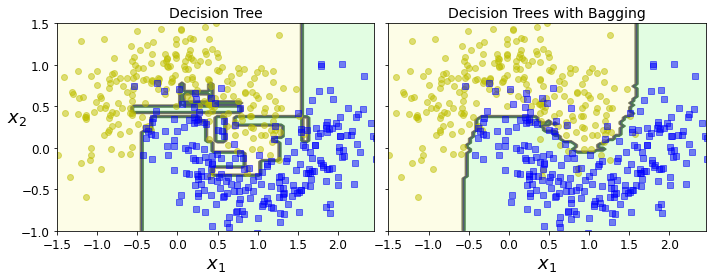


일반적으로 배깅이 페이스팅에 비해 편향이 더 크며 분산이 더 작다.

앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

대체적으로 배깅이 더 나은 모델을 만든다.


#### OOB 평가


배깅은 중복을 허용하여 샘플을 추출하기에 한 번도 사용되지 않는 샘플이 존재한다. 이와 같이 훈련시에 선택되지 않은 훈련 샘플을 **oob(out-of-bag) 샘플**이라고 부른다.

이와 같이 한번도 사용되지 않은 샘플인 oob를 통해 앙상블 학습의 개별 예측기의 성능을 평가하는 것을 **oob 평가**라고 부른다.

각 예측기의 oob 평가 점수를 평균하여 앙상블의 oob 평가 점수를 산출한다.

> BaggingClassifier에서 `oob_score=True`를 통해 oob 평가를 수행할 수 있다.


In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.8986666666666666

### 랜덤 패치와 랜덤 서브스페이스(11페이지)


TBD


## 랜덤 포레스트


배깅/페이스팅 방법을 적용한 결정 트리의 앙상블을 **랜덤 포레스트**라고 부른다.

- 트리의 노드를 분할할 때 최선의 특성 보다는 무작위성을 가진 특성을 사용하여 분할한다.

- 이를 통해 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 다양한 트리를 만든다.


In [22]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier를 사용한 분류기 선언
rnd_clf = RandomForestClassifier(n_estimators=500,  # 500개의 트리를 생성
                                 max_leaf_nodes=16,  # 각 트리의 최대 리프 노드 개수
                                 random_state=42)

# RandomForestClassifier 학습
rnd_clf.fit(X_train, y_train)

# 예측 정확도 출력
y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.912


배깅을 통해 수행된 내용과 비교해 보았을 때 모든 예측 값이 일치함을 확인할 수 있다.

이를 통해 **결정 트리를 배깅 방식으로 앙상블한 것이 랜덤 포레스트**임을 알 수 있다.


In [24]:
import numpy as np

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# 랜덤 포레스트 예측값과 배깅 예측값이 같은지 1대 1로 비교한 뒤 정확도를 출력한다.
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

### 엑스트라 트리


랜덤 포레스트는 무작위 선택을 통해 특성을 선택하여 노드를 분할한다. 이때 특성 임계값은 무작위 분할을 수행한 뒤 최적값을 선택한다.

하지만 특성과 특성 임곗값 모두 무작위로 선택하는 것을 **엑스트라 트리**라고 부른다.

<br>

극단적으로 무작위한 트리인 엑스트라 트리는 일반적인 랜덤 포레스트보다 훈련이 빠르다.

하지만 일반적으로 랜덤 포레스트보다 성능이 떨어진다.

> 엑스트라 트리 역시 앙상블 모델이기에 편향은 높아지지만 분산은 낮아진다.


### 특성 중요도


해당 특성을 사용한 노드가 평균적으로 **불순도를 얼마나 많이 감소시키는지**를 측정하여 특성의 중요도를 측정할 수 있다.

RandomForestClassifier의 `feature_importances_`를 통해 특성 중요도를 확인할 수 있으며 중요도의 총 합은 1이다.(1이 되도록 정규화 함)


In [27]:
# Load dataset
from sklearn.datasets import load_iris
iris = load_iris()

# RandomForestClassifier를 사용한 분류기 선언 및 학습
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

# 각 특성과 특성 중요도 점수를 출력한다.
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

# 특성 중요도 점수의 총합이 1임을 확인할 수 있다.
print(f'\nScore Sum: {rnd_clf.feature_importances_.sum()}')

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682

Score Sum: 1.0


아래와 같이 데이터에 대한 특성 중요도를 확인할 수 있다.


In [ ]:
from sklearn.datasets import fetch_openml

# MNIST 데이터셋을 로드한다.
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])


def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")


plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(
    ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## 부스팅


부스팅(boosting)이란 순차적으로 성능이 약한 이진 학습기의 결과를 바탕으로 성능을 조금씩 높여나가서 강한 성능의 학습기를 만드는 앙상블 기법이다.

순차적으로 학습하기에 배깅/페이스팅에 비해 확장성이 떨어지지만 꾸준하게 성능이 증가한다는 강점이 있다.

대표적인 부스팅에는 에이다부트스트, 그레이디언트 부스팅이 있다.


### 에이다부스트


기존 병렬적으로 나열되었던 학습기와 달리 에이다부스트(AdaBoost - Adaptive Boosting)는 이전 학습기의 예측이 잘못된(과소적합) 샘플에 가중치를 높여 다음 학습기에 적용하는 방식이다.

에이다 부스트는 비용함수를 최소화 하는 대부분의 기계학습 모델과 달리 예측 성능을 최대화 하는 방향으로 학습을 진행한다.

에이다 부스트는 예측 성능을 높이기 위하여 가중치 조절과 더불어 현재 모델을 통해 예측을 수행할 수 없는 데이터를 예측기를 추가하여 대응한다.

<img src="https://velog.velcdn.com/images/kyungmin1029/post/aa6e33a1-b27f-471b-bd63-260a0b082211/image.png">


In [30]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoostClassifier를 사용한 분류기 선언
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,     # 200개의 트리를 생성
    algorithm="SAMME.R",  # SAMME.R: 예측값을 확률로 출력
    learning_rate=0.5,    # 학습률
    random_state=42)

# AdaBoostClassifier 학습
ada_clf.fit(X_train, y_train)

# 예측 정확도 출력
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.896


### 그레이디언트 부스팅


이진 학습기에 의한 오차를 보정하도록 새로운 학습기를 추가하는 방식은 에이다 부스트와 동일하다.

하지만 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차(residual error)**에 새로운 예측기를 학습시킨다.

> 잔여 오차(이전 예측기의 예측값과 실제값의 오차)는 경사 하강법을 통해 최적화한다.


#### Code: 그레이디언트 부스팅 회귀


그레이디언트 부스팅 회귀(GBRT)는 각 결정트리에서 도출된 예측값을 통해 잔여 오차를 구하고 이를 기반으로 다음 결정트리를 학습시키는 과정을 반복한다.


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# 첫번째 결정 트리 학습
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# 첫번째 결정 트리의 잔여 오차를 기반으로 두번째 결정 트리를 학습
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# 두번째 결정 트리의 잔여 오차를 기반으로 세번째 결정 트리를 학습
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

위의 tree_reg1, tree_reg2, tree_reg3는 각각 아래와 같다.

좌측 그래프는 잔여 오차에 대한 회귀 트리의 예측값이며 우측 그래프는 이를 누적한 결과이다.


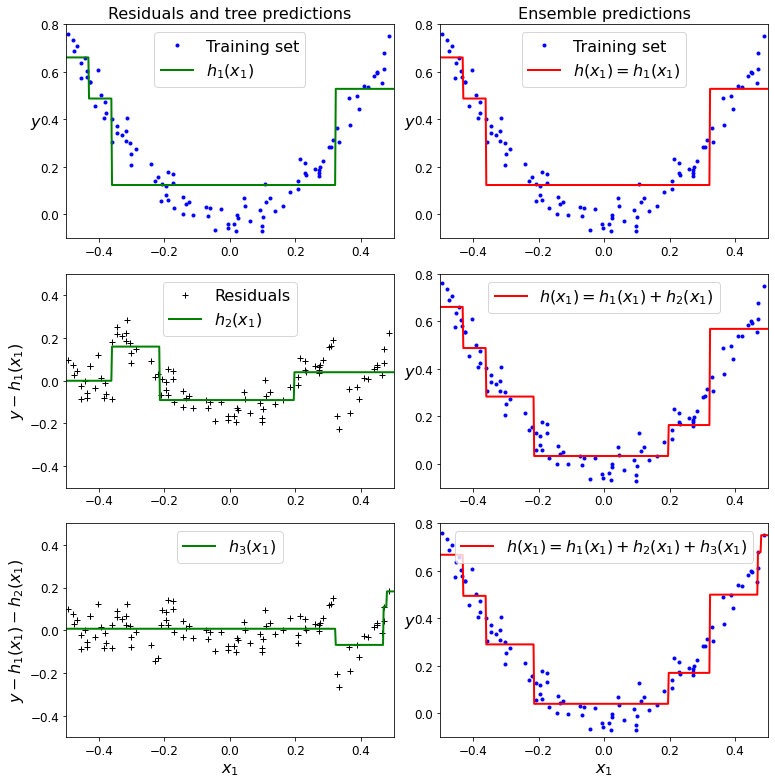


그레디언트 부스팅은 위 과정을 자동화한 것으로 `GradientBoostingClassifier` 클래스를 통해 구현할 수 있다.


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2,        # 각 결정 트리의 최대 깊이
    n_estimators=3,     # 트리의 개수
    learning_rate=1.0,  # 학습률
    random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)